# **ASAH (Aplikasi Sortir Sampah)**

Ini merupakan repository untuk pembuatan model machine learning klasifikasi gambar sampah untuk proyek akhir Bangkit Academy 2023.

Anggota Machine Learning:
- Edwin Mahendra
- Johannes Baptista Adiatmaja Pambudi

# **Import Library**

Diperlukan import library berikut untuk mengerjakan proyek ini.

In [1]:
import os
import shutil
import zipfile
import pathlib
import random

import cv2

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

Cek versi tensorflow

In [2]:
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.12.0


# **Dataset Preparation**

Dataset yang digunakan adalah dataset Garbage Classification yang memuat 12 jenis sampah. Dataset ini diperoleh dari kaggle dengan link: https://www.kaggle.com/datasets/mostafaabla/garbage-classification/code

In [3]:
! pip install -q kaggle

In [4]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"{your_username}","key":"{your_api_key}"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download mostafaabla/garbage-classification

 97% 232M/239M [00:01<00:00, 207MB/s]
100% 239M/239M [00:01<00:00, 184MB/s]


In [6]:
local_zip = 'garbage-classification.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [7]:
PATH = '/content/garbage_classification'

# **Explore Dataset**

Menggabungkan beberapa kelas, diantaranya: 'brown-glass'; 'green-glass'; 'white-glass' menjadi sebuah kelas bernama 'gelas'

In [8]:
old_PATH = '/content/garbage_classification'
new_PATH = '/content/garbage_classification_merged'  # New path

old_data_dir = pathlib.Path(old_PATH)
new_data_dir = pathlib.Path(new_PATH)  # New data directory

os.makedirs(new_data_dir, exist_ok=True)

# Initialize counts
glass_count = 0 
class_labels = []
class_counts = []

for original_label in os.listdir(old_data_dir):
    old_label_dir = os.path.join(old_data_dir, original_label)
    count_label_dir = len(os.listdir(old_label_dir))
    new_label_dir = os.path.join(new_data_dir, original_label)
    if 'glass' in original_label:
        new_label_dir = os.path.join(new_data_dir, 'glass')
        if 'glass' not in class_labels:
            class_labels.append('glass')
            class_counts.append(0)
        glass_count += count_label_dir
        class_counts[class_labels.index('glass')] = glass_count
    else:
        class_labels.append(original_label)
        class_counts.append(count_label_dir)

    os.makedirs(new_label_dir, exist_ok=True)

    for file_name in os.listdir(old_label_dir):
        shutil.move(os.path.join(old_label_dir, file_name), new_label_dir)


Visualisasi Data


Distribution of Images in the new location:
1. metal : 769
2. plastic : 865
3. cardboard : 891
4. glass : 2011
5. paper : 1050
6. battery : 945
7. trash : 697
8. clothes : 5325
9. biological : 985
10. shoes : 1977

Total images from this dataset: 15515



========== Bar Graph ==========


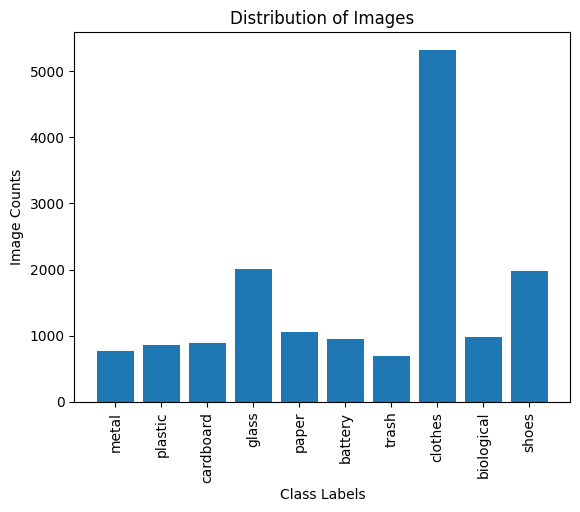

In [9]:
new_class_labels = []
new_class_counts = []

print('\nDistribution of Images in the new location:')
for i, label in enumerate(os.listdir(new_data_dir)):
    label_dir = os.path.join(new_data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label} : {len_label_dir}')
    new_class_labels.append(label)
    new_class_counts.append(len_label_dir)

# Check total in new directory
image_count = len(list(new_data_dir.glob('*/*.jpg')))
print(f'\nTotal images from this dataset: {image_count}')

print('\n\n')
print('========== Bar Graph ==========')
# Create a bar graph
plt.bar(new_class_labels, new_class_counts)
plt.xlabel('Class Labels')
plt.ylabel('Image Counts')
plt.title('Distribution of Images')
plt.xticks(rotation=90)
plt.show()

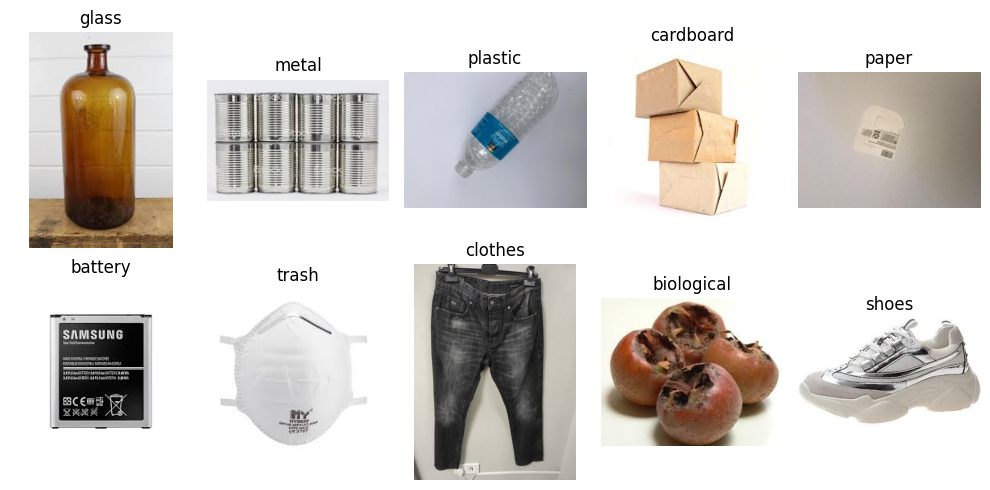

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i, label in enumerate(class_labels):
    label_dir = os.path.join(new_data_dir, label)
    image_files = os.listdir(label_dir)
    random_image_file = random.choice(image_files)
    image_path = os.path.join(label_dir, random_image_file)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# **Data Preprocessing & Transformation**

**Set Up Parameter**

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 66


**Divide Data into Train and Validation Test**

Proses selanjutnya adalah pembagian Dataset. Dataset akan dibagi menjadi train dan validation test. Data train atau latih akan digunakan untuk membangun model, sedangkan data validation dan test akan digunakan untuk menguji performa model. Pada proyek ini dataset sebesar 15.515 data gambar akan dibagi menjadi 80% (Train Set Data) dan 20% (Validation Set Data).

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  new_data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  new_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 15515 files belonging to 10 classes.
Using 12412 files for training.
Found 15515 files belonging to 10 classes.
Using 3103 files for validation.


In [13]:
class_names = train_ds.class_names
class_names_val = val_ds.class_names

**Test Data**

Membagi validation set data untuk menghasilkan test data

In [14]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 78
Number of test batches: 19


**Data Performance**

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(image_count//4).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Build a Model**



In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.RandomZoom(0.2)],
  tf.keras.layers.RandomZoom(0.1)],
  name="data_augmentation")

KeyboardInterrupt: ignored

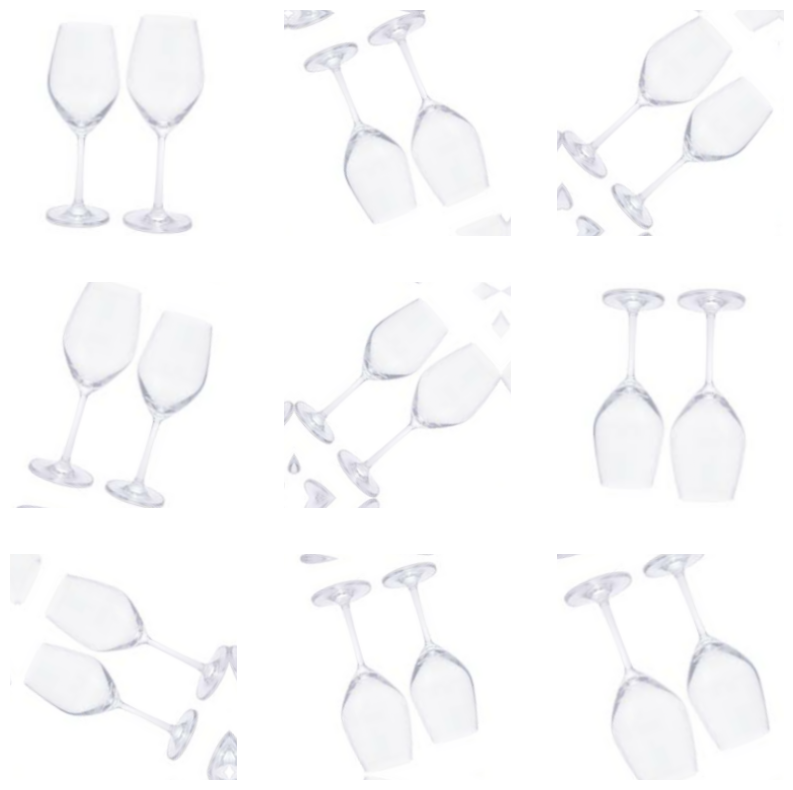

In [17]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

9406464/9406464 [==============================] - 0s 0us/step


In [19]:
def model_builder():
  num_classes = len(class_names)

  model = tf.keras.Sequential()

  model.add(inputs)
  model.add(data_augmentation)
  model.add(normalization_layer)
  model.add(base_model)
  model.add(global_average_layer)

  model.add(tf.keras.layers.Dense(units=512, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(num_classes, 
                                  activation='softmax', 
                                  name="final_output"))

  base_learning_rate = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

In [20]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=10, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

# **Model Training**

In [21]:
model = model_builder()
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
387/388 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.8288
Epoch 1: val_accuracy improved from -inf to 0.90661, saving model to checkpoint_model.h5
388/388 [==============================] - 43s 79ms/step - loss: 0.5179 - accuracy: 0.8292 - val_loss: 0.2877 - val_accuracy: 0.9066
Epoch 2/100
387/388 [============================>.] - ETA: 0s - loss: 0.3383 - accuracy: 0.8859
Epoch 2: val_accuracy improved from 0.90661 to 0.91984, saving model to checkpoint_model.h5
388/388 [==============================] - 21s 53ms/step - loss: 0.3386 - accuracy: 0.8859 - val_loss: 0.2351 - val_accuracy: 0.9198
Epoch 3/100
388/388 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8983
Epoch 3: val_accuracy improved from 0.91984 to 0.92144, saving model to checkpoint_model.h5
388/388 [==============================] - 21s 53ms/step - loss: 0.2991 - accuracy: 0.8983 - val_loss: 0.2366 - val_accuracy: 0.9214
Epoch 4/100
388/388 [================

# **Accuracy and Plot Lost Graph Model MobileNetV2**

In [22]:
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-22-447fa776aed2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


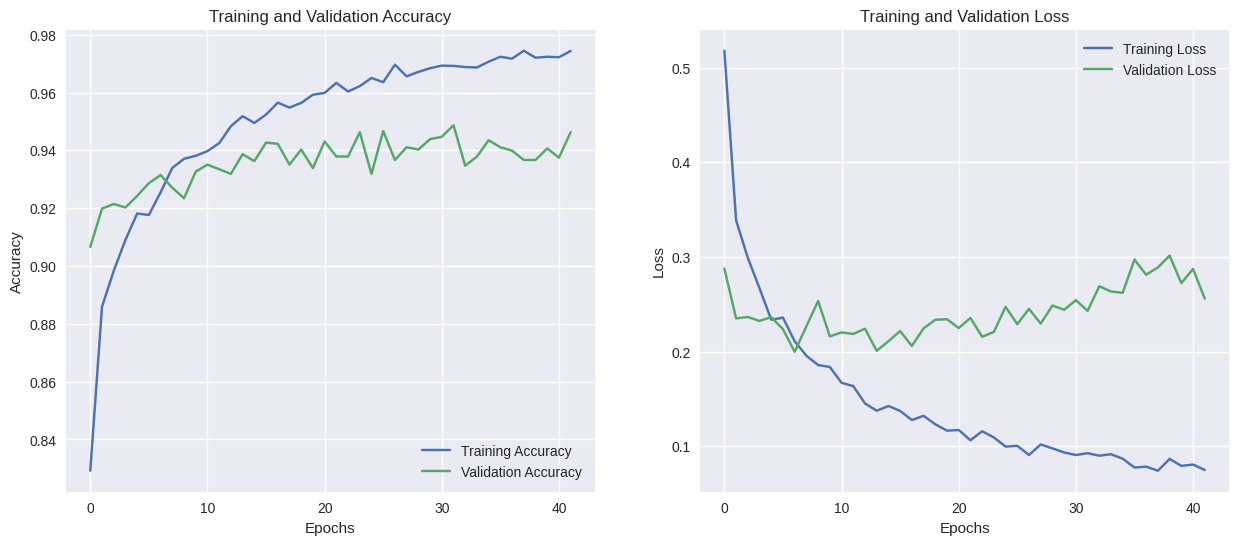

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Evaluating Model**

In [24]:
load_model = tf.keras.models.load_model('checkpoint_model.h5')
load_model.evaluate(x=test_dataset, return_dict=True)

19/19 [==============================] - 3s 77ms/step - loss: 0.2575 - accuracy: 0.9457


{'loss': 0.2574857771396637, 'accuracy': 0.9457237124443054}

# **Testing Model**

In [ ]:
# class_names = np.array(class_names)
# class_names_val = np.array(class_names_val)

# print(f'List label Train data: \n{class_names}\n')
# print(f'List label Validation data: \n{class_names_val}')

# image_batch_test, label_batch_test = next(iter(test_dataset))

# image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()


# predicted_batch = load_model.predict(image_batch_test)
# predicted_batch = tf.squeeze(predicted_batch).numpy()

# predicted_ids = np.argmax(predicted_batch, axis=-1)
# predicted_class_names = class_names[predicted_ids]

# print(predicted_class_names)

In [ ]:
# print(f"Labels:\n{label_batch_test}")
# print(f"Predicted labels:\n{predicted_ids}")

# true_predict = 0
# false_predict = 0

# for i in predicted_ids:
#   if i in label_batch_test:
#     true_predict +=1
#   else:
#     false_predict +=1

# print()
# print(f'True Predict Count : {true_predict}')
# print(f'False Predict Count : {false_predict}')

In [ ]:
# plt.figure(figsize=(15,10))
# plt.subplots_adjust(hspace=0.3)

# for n in range(30):
#   plt.subplot(6,5,n+1)
#   plt.imshow(image_batch_test[n].astype('uint8'))
#   color = "blue" if predicted_ids[n] == label_batch_test[n] else "red"
#   plt.title(predicted_class_names[n].title(), color=color)
#   plt.axis('off')
# _ = plt.suptitle("Model predictions")

Saving WhatsApp Image 2023-05-17 at 21.18.45 (1).jpeg to WhatsApp Image 2023-05-17 at 21.18.45 (1) (1).jpeg
1/1 [==============================] - 0s 26ms/step


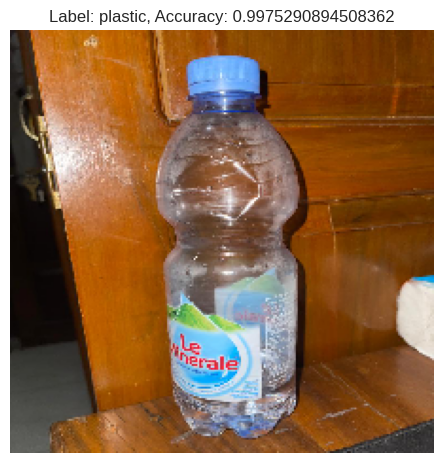

In [27]:
import keras.utils as image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=IMG_SIZE + (3,))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = load_model.predict(images, batch_size=10)
    outclass = np.argmax(classes)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Label: {class_names[outclass]}, Accuracy: {classes[0][outclass]}')
    plt.show()

**Testing with sklearn()**

In [ ]:
# x_test = []
# y_test = []

# for x_batch, y_batch in test_dataset:
#   for x_i, y_i in zip(x_batch, y_batch):
#     x_test.append(x_i)
#     y_test.append(y_i)

# x_test = np.array(x_test)
# y_test = np.array(y_test)

In [ ]:
# # Testing accuracy with the test data
# from sklearn.metrics import accuracy_score
 
# pred=np.argmax(model.predict(x_test), axis=-1)
# accuracy = accuracy_score(y_test, pred)
# print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
# # Calculate metrics for classification
# from sklearn.metrics import classification_report
 
# print(classification_report(y_test, pred))